# The Representation of an Algorithm Impacts its Maliciousness

In [44]:
from collections import defaultdict
from dataclasses import dataclass
from importlib import reload
from itertools import chain, combinations
import os
from pathlib import Path
from pprint import pprint
import shutil
import statistics
import subprocess
import sys
import typing as tp

In [2]:
WINDOWS = False

In [3]:
ALGORITHM = ("heapsort", "mergesort", "quicksort")
ENCRYPTION = ("openssl",)  # "cryptoppe", "tomcrypt"
PACKING = ("None", "upx",)  # "exepacker"
INPUT_ROOT = Path(".")
OUTPUT_ROOT = Path("./outputs/concept")
ANACONDA = "C:\\Users\Luke\\anaconda3\\"

In [4]:
class InputHelper:
    
    def __init__(self, algorithm: str, encryption: str) -> None:
        self.algorithm = algorithm
        self.encryption = encryption

    @property
    def root(self) -> Path:
        return INPUT_ROOT
        
    @property
    def path(self) -> Path:
        return self.root / self.algorithm / self.encryption
    
    @property
    def source_file(self) -> Path:
        return self.path / "main.cpp"


class OutputHelper:
    
    def __init__(self, algorithm: str, encryption: str, packing: str) -> None:
        self.algorithm = algorithm
        self.encryption = encryption
        self.packing = packing
    
    def mkdir(self, exist_ok: bool = False, parents: bool = False) -> None:
        self.path.mkdir(exist_ok=exist_ok, parents=parents)
        self.binaries_path.mkdir(exist_ok=exist_ok)
    
    @property
    def root(self) -> Path:
        return OUTPUT_ROOT
        
    @property
    def path(self) -> Path:
        return self.root / str(self.algorithm) / str(self.encryption) / str(self.packing)

    @property
    def binaries_path(self) -> Path:
        return self.path / "binaries"
    
    @property
    def binaries(self) -> Path:
        return list(self.binaries_path.iterdir())

## Create Diverse Executables

This needs to be run on my Windows Machine

In [54]:
def _get_compiler_flags() -> tp.List[tp.List[str]]:
    mixxy = [  # can be mixed together with each other
        "-fno-inline",
        "-fno-function-cse",
        "-fno-guess-branch-probability",
        "-fno-tree-loop-distribute-patterns",
    ]
    nomixy = [  # can not be mixed with each other
        "-O0", "-O2", "-O3",
    ]
    flags = list(chain.from_iterable([[i for i in combinations(mixxy, l)] for l in range(len(mixxy))]))
    flags = list(chain.from_iterable([[list(x) + [n] for n in nomixy] for x in flags]))
    return flags


class Compiler:
    
    flag_options = _get_compiler_flags()
    
    def __init__(self, source: str, algorithm: str, encryption: str) -> None:
        self.source = Path(source)
        self.flags = [f"{algorithm}.cpp"]
        if encryption == "openssl":
            self.flags.extend([
                "opensslencryption.cpp",
                f"-I'{ANACONDA}include'",
                f"-L'{ANACONDA}libs'",
                "-lssl",
                "-lcrypto",
            ])
        elif encryption == "cryptoppe":
            raise NotImplementedError()
        elif encryption == "tomcrypt":
            raise NotImplementedError()

    def __call__(self, out: Path) -> tp.List[Path]:
        successes = []
        for i, var_flags in enumerate(self.flag_options):
            o = out / str(i)
            args = ["g++", self.source.as_posix()] + self.flags + ["-o", o.as_posix()] + var_flags
            result = subprocess.run(args, capture_output=True, text=True)
            stdout = str(result.stdout)
            stderr = str(result.stderr)
            if stdout:
                print(" ".join(args), f"\n{stdout}")
            if stderr:
                print(" ".join(args), f"\n{stderr}")
            else:
                print(" ".join(args), "\n...SUCCESS...\n")
                successes.append(o)
        return successes

In [6]:
if WINDOWS:
    for alg in ALGORITHM:
        for enc in ENCRYPTION:
            input_helper = InputHelper(alg, enc)
            compiler = Compiler(input_helper.source_file, alg, enc)
            for pck in PACKING:
                output_helper = OutputHelper(alg, enc, pck)
                output_helper.mkdir(True, True)
                compiler(output_helper.binaries_path)

# Apply Obfuscation

Henceforth, we switch over to a Linux OS

In [7]:
os.chdir("/home/lk3591/Documents/code/MalConv2")

In [8]:
def pack(pck: str, infile: Path, outfile: Path) -> bool:
    outfile.unlink(missing_ok=True)
    
    if pck == "upx":
        args = ["/home/lk3591/.local/share/upx-4.0.1-amd64_linux/upx", "-o", outfile.as_posix(), infile.as_posix()]
    elif pck == "exepacker":
        raise NotImplementedError()
    else:
        raise ValueError(f"{pck=} not recognized.")
    
    result = subprocess.run(args, capture_output=True, text=True)
    stdout = str(result.stdout)
    stderr = str(result.stderr)
    
    if stdout:
        print(" ".join(args), f"\n{stdout}")
    if stderr:
        print(" ".join(args), f"\n{stderr}")
        return False
    return True

In [ ]:
for alg in ALGORITHM:
    for enc in ENCRYPTION:
        source = OutputHelper(alg, enc, None).binaries
        for pck in PACKING:
            if str(pck) == "None":
                continue
            target = OutputHelper(alg, enc, pck).binaries_path
            for f in source:
                pack(pck, f, target / f.name)

In [13]:
from captum.attr import FeatureAblation, KernelShap
import lief
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import tensor
from tqdm import tqdm

import cfg
from classifier import confidence_scores, forward_function_malconv, get_dataset_and_loader, get_model
from executable_helper import read_binary, stream_text_section_bounds
from explain import FeatureMask, BASELINE, TARGET
import utils
from utils import batch

In [10]:
cfg.init("cuda:1", 0)

----------------------------------------------------------------------------------------
---------------------------------------- CONFIG ----------------------------------------
----------------------------------------------------------------------------------------
seed=0
device=device(type='cuda', index=1)
torch.backends.cudnn.enabled=False


## Analyze Executables

In [16]:
def get_confidence_scores_from_files(model, files: tp.List[Path]) -> tp.List[float]:
	confidences = []
	for f in files:
		x = read_binary(f)
		x = tensor(x, dtype=torch.int64)
		c = confidence_scores(model, x)
		confidences.append(c[0])
	return confidences

@dataclass
class Result:
    alg: str
    enc: str
    pck: str
    confidences: np.ndarray
    malratio: np.ndarray
    conf_mean: float = np.NaN
    conf_median: float = np.NaN
    conf_max: float = np.NaN
    conf_min: float = np.NaN
    malratio_mean: float = np.NaN
    malratio_median: float = np.NaN
    malratio_max: float = np.NaN
    malratio_min: float = np.NaN
    
    def __post_init__(self):
        if self.confidences.size > 0:
            self.conf_mean = np.mean(self.confidences)
            self.conf_median = np.median(self.confidences)
            self.conf_max = np.max(self.confidences)
            self.conf_min = np.min(self.confidences)

        if self.malratio.size > 0:
            self.malratio_mean = np.mean(malratio)
            self.malratio_median = np.median(malratio)
            self.malratio_max = np.max(malratio)
            self.malratio_min = np.max(malratio)

The explanation portion appears to have some sort of bug in it because it returns different values for the same executable...

In [ ]:
model = get_model("gct").to(cfg.device)
forward_function = forward_function_malconv(model, False)
explainer = FeatureAblation(forward_function)
batch_size = 32
feature_mask_size = 256
feature_mask_mode = "all"
results = []
for alg in ALGORITHM:
    print(f"{'-' * 10} {alg} {'-' * 10}")
    for enc in ENCRYPTION:
        for pck in reversed(PACKING):
            print(f"{'-' * 5}      {pck}      {'-' * 5}")
            output_helper = OutputHelper(alg, enc, pck)
            dataset, loader = get_dataset_and_loader(
                None, output_helper.binaries, batch_size=batch_size
            )
            files = [Path(e[0]) for e in dataset.all_files]
            
            confidences = get_confidence_scores_from_files(model, files)
            
            malratio = []
            bounds = batch(stream_text_section_bounds(files, "pefile", errors="ignore"), batch_size)
            
            for bounds_batch, (inputs, _) in tqdm(zip(bounds, loader), total=len(loader)):
                inputs = inputs.to(cfg.device)
                lowers = [l for _, l, _ in bounds_batch]
                uppers = [u for _, _, u in bounds_batch]
                
                
                feature_mask = FeatureMask(
                    inputs,
                    feature_mask_size,
                    feature_mask_mode,
                    lowers,
                    uppers,
                )().to(cfg.device)
                
                attribs = explainer.attribute(inputs, BASELINE, TARGET, feature_mask=feature_mask)
                for a, l, u in zip(attribs, lowers, uppers):
                    malratio.append((torch.sum(a[l:u]) / torch.sum(a)).item())
            
            result = Result(alg, enc, pck, np.array(confidences), np.array(malratio))
            results.append(result)

In [ ]:
results

## Plotting

In [19]:
COLORS = ["red", "blue", "green", "orange", "purple"]
MARKERS = [".", "x", "+", "1", "2"]

In [26]:
def get_result(alg, enc, pck):
    for r in results:
        if r.alg == alg and r.enc == enc and r.pck == pck:
            return r
    raise Exception()

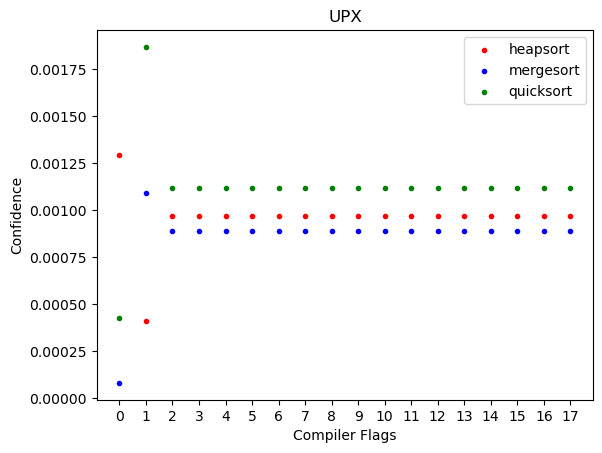

In [40]:
for i, alg in enumerate(ALGORITHM):
    for j, enc in enumerate(ENCRYPTION):
        for k, pck in enumerate(("None",)):
            result = get_result(alg, enc, pck)
            plt.scatter(x=list(range(len(result.confidences))), y=result.confidences, color=COLORS[i], marker=MARKERS[k], label=alg)
plt.legend()
plt.title("UPX")
plt.ylabel("Confidence")
plt.xlabel("Compiler Flags")
_ = plt.xticks(list(range(len(result.confidences))))

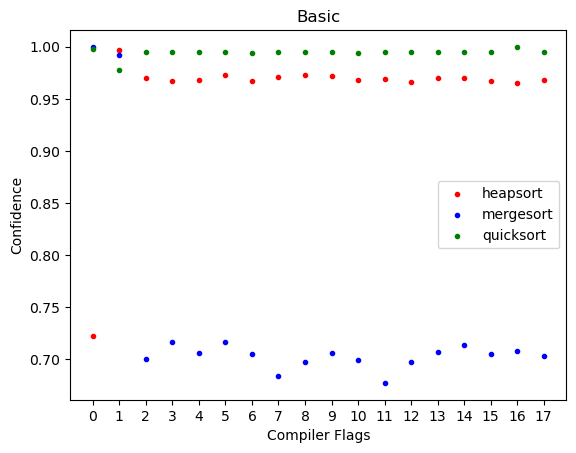

In [41]:
for i, alg in enumerate(ALGORITHM):
    for j, enc in enumerate(ENCRYPTION):
        for k, pck in enumerate(("upx",)):
            result = get_result(alg, enc, pck)
            plt.scatter(x=list(range(len(result.confidences))), y=result.confidences, color=COLORS[i], marker=MARKERS[k], label=alg)
plt.legend()
plt.title("Basic")
plt.ylabel("Confidence")
plt.xlabel("Compiler Flags")
_ = plt.xticks(list(range(len(result.confidences))))

## Swap .text Sections Confidence Scores

In [ ]:
def swap_text_sections(f_source: Path, f_replace: Path) -> Path:
    source = lief.parse(f_source.as_posix())
    replace = lief.parse(f_replace.as_posix())
    source_text = source.get_section(".text")
    replace_text = replace.get_section(".text")
    source.remove(source_text)
    source.add_section(replace_text)
    
    builder = lief.PE.Builder(source)
    builder.build_imports(True)
    builder.build()
    f_out = f_source.parent / (f_source.stem + f_replace.stem + ".exe")
    builder.write(f_out.as_posix())

    return f_out

In [ ]:
for f_source in executables:
    for f_replace in [f for f in executables if f != f_source]:
        f_out = swap_text_sections(f_source, f_replace)
        confidences[f_source.stem][f_replace.stem] = get_confidence_scores_from_files([f_out])[0]
        if WINDOWS:
            subprocess.run(f"./{f_out}")

In [ ]:
pprint(confidences)
max_and_min_confidences(confidences)

# Main

In [59]:
import utils
reload(utils)


x = [("Hi", 1) for _ in range(10)]
for b in utils.batch(x, 3):
    print(b)

x = (("Hi", 1) for _ in range(10))
for b in utils.batch(x, 3):
    print(b)

[('Hi', 1), ('Hi', 1), ('Hi', 1)]
[('Hi', 1), ('Hi', 1), ('Hi', 1)]
[('Hi', 1), ('Hi', 1), ('Hi', 1)]
[('Hi', 1)]
[('Hi', 1), ('Hi', 1), ('Hi', 1)]
[('Hi', 1), ('Hi', 1), ('Hi', 1)]
[('Hi', 1), ('Hi', 1), ('Hi', 1)]
[('Hi', 1)]
